In [0]:
#Install extra lib(s)
!pip install -q xlrd
!pip install -q kaggle
!pip install -q kora

import kora
import pandas as pd

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import *

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-b0a962b2-f89e-4e19-bec9-b5f178fb04ca/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-b0a962b2-f89e-4e19-bec9-b5f178fb04ca/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-b0a962b2-f89e-4e19-bec9-b5f178fb04ca/bin/python -m pip install --upgrade pip' command.


In [0]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

%matplotlib inline

#Getting Mock Dataset

We also want to have some data to work with. A simple way to get that is to generate it using scikit-learn's method to generate ten blobs in a three-dimensional space.

To make it more realistic we also add an 'id' column of strings, which in real life is often the customer id or the IP address of the IoT device, or similar.

Last we write the dataset as a CSV file, which despite being an awful format, is the one I encounter every day.

In [0]:
n_samples=10000
n_features=3
X, y = make_blobs(n_samples=n_samples, centers=10, n_features=n_features, random_state=42)

# add a row index as a string
pddf = pd.DataFrame(X, columns=['x', 'y', 'z'])
pddf['id'] = 'row'+pddf.index.astype(str)

#move it first (left)
cols = list(pddf)
cols.insert(0, cols.pop(cols.index('id')))
pddf = pddf.loc[:, cols]
pddf.head()

file_path = 'dbfs:/temp/input.csv'

# save the ndarray as a csv file
pddf.to_csv("input.csv", index=False)

<command-3168712444199820>:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure(figsize=(12,10)).gca(projection='3d')


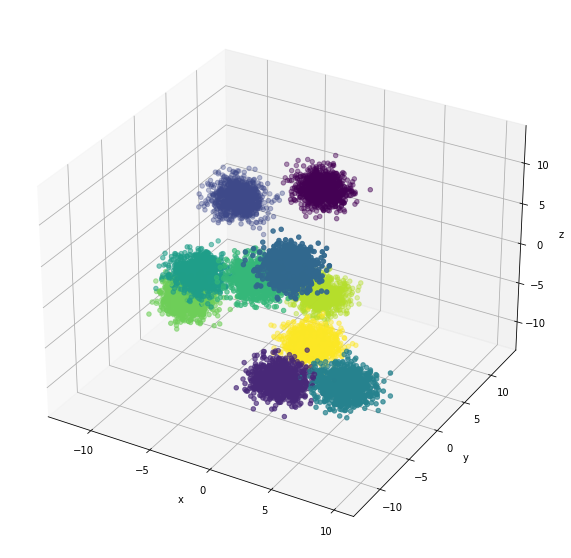

In [0]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(X[:,0], X[:,1], X[:,2], c=y)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

#Exploring Data

In [0]:
FEATURES_COL = ['x', 'y', 'z']
path = 'input.csv'

In [0]:
#df = spark.read.options(header="true",inferschema = "true").csv(path)
df = spark.createDataFrame(pddf) 
df.show()

+-----+--------------------+-------------------+-------------------+
|   id|                   x|                  y|                  z|
+-----+--------------------+-------------------+-------------------+
| row0|  -6.077699676970267|-2.9096103057273632|-1.5181728865169748|
| row1| -1.0122600489217026|  7.322841304183577| -5.442407430432608|
| row2|  -8.297006462627731| 6.3228935430154625|  1.167204760454971|
| row3|  -3.507121456057238|  4.784811751712145|  -5.44494747291675|
| row4|   -5.12282340491732| -3.322049741451506|-0.5069804719890176|
| row5|  -2.476400627641164|  8.255790793498251| 4.4094781220223345|
| row6|   7.315395347991067| -5.079448952098217| -7.291214948142356|
| row7|  -2.016746359044601|   9.30345477210614|  7.095178976138996|
| row8|-0.23381850372561575| -4.892681101883508| 2.1228876266871093|
| row9|   6.565442081261875| -6.855994160254796| -6.798321268724102|
|row10|  -5.690284570490115| -6.482740258743004|-0.9246966808128123|
|row11|-0.01798614270656...|  2.76

##Check Schema and DataType

In [0]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



##Check "Null"

In [0]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+---+---+
| id|  x|  y|  z|
+---+---+---+---+
|  0|  0|  0|  0|
+---+---+---+---+



In [0]:
df.describe().show()

+-------+-------+-------------------+-------------------+-------------------+
|summary|     id|                  x|                  y|                  z|
+-------+-------+-------------------+-------------------+-------------------+
|  count|  10000|              10000|              10000|              10000|
|   mean|   null|-1.4042826560813697|-1.0639771040701733|-1.2173489481292035|
| stddev|   null|  4.825849327260171|  6.276823840204036|  5.728730293325619|
|    min|   row0| -12.07984158196513|-12.555063182824682|-11.886802240077339|
|    max|row9999|  9.934576529690277| 12.940523834634648| 12.775965284529248|
+-------+-------+-------------------+-------------------+-------------------+



In [0]:
##In case you need to remove null
df = df.na.drop()
df.show()

+-----+--------------------+-------------------+-------------------+
|   id|                   x|                  y|                  z|
+-----+--------------------+-------------------+-------------------+
| row0|  -6.077699676970267|-2.9096103057273632|-1.5181728865169748|
| row1| -1.0122600489217026|  7.322841304183577| -5.442407430432608|
| row2|  -8.297006462627731| 6.3228935430154625|  1.167204760454971|
| row3|  -3.507121456057238|  4.784811751712145|  -5.44494747291675|
| row4|   -5.12282340491732| -3.322049741451506|-0.5069804719890176|
| row5|  -2.476400627641164|  8.255790793498251| 4.4094781220223345|
| row6|   7.315395347991067| -5.079448952098217| -7.291214948142356|
| row7|  -2.016746359044601|   9.30345477210614|  7.095178976138996|
| row8|-0.23381850372561575| -4.892681101883508| 2.1228876266871093|
| row9|   6.565442081261875| -6.855994160254796| -6.798321268724102|
|row10|  -5.690284570490115| -6.482740258743004|-0.9246966808128123|
|row11|-0.01798614270656...|  2.76

#Prep data for model
Doing some vertorizing

In [0]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('id', 'features')
df_kmeans.show()

+-----+--------------------+
|   id|            features|
+-----+--------------------+
| row0|[-6.0776996769702...|
| row1|[-1.0122600489217...|
| row2|[-8.2970064626277...|
| row3|[-3.5071214560572...|
| row4|[-5.1228234049173...|
| row5|[-2.4764006276411...|
| row6|[7.31539534799106...|
| row7|[-2.0167463590446...|
| row8|[-0.2338185037256...|
| row9|[6.56544208126187...|
|row10|[-5.6902845704901...|
|row11|[-0.0179861427065...|
|row12|[-6.9042625162071...|
|row13|[-10.389865177604...|
|row14|[3.96886833004396...|
|row15|[-7.3370519870306...|
|row16|[-8.9915883100353...|
|row17|[-0.1809858409434...|
|row18|[3.31939544014348...|
|row19|[-2.0266334941663...|
+-----+--------------------+
only showing top 20 rows



##Optimize choice of k
One disadvantage of KMeans compared to more advanced clustering algorithms is that the algorithm must be told how many clusters, k, it should try to find. 

###Elbow Method
To optimize k we cluster a fraction of the data for different choices of k and look for an "elbow" in the cost function.

(However, may not good due to require to convert to PD)

In [0]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.summary.trainingCost # requires Spark 2.0 or later

Out[21]: Text(0, 0.5, 'cost')

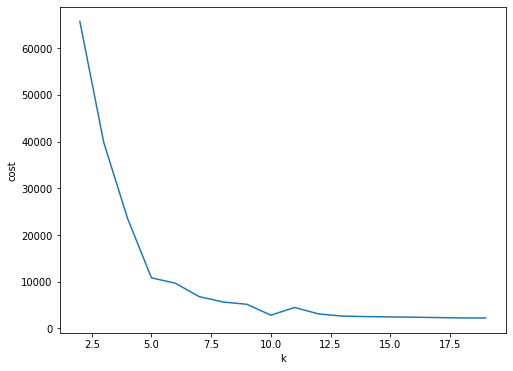

In [0]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

###Silhouette
The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

The silhouette can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance.

In [0]:
from pyspark.ml.evaluation import *

cost = list()
evaluator = ClusteringEvaluator()
for k in range(2,20):
    bkm = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    bkm_model = bkm.fit(df_kmeans.sample(False,0.1, seed=42))
    tags_predictions = bkm_model.transform(df_kmeans.sample(False,0.1, seed=42))
    silhouette = evaluator.evaluate(tags_predictions)
    cost.append(silhouette)
    
kIdx = np.argmax(cost)


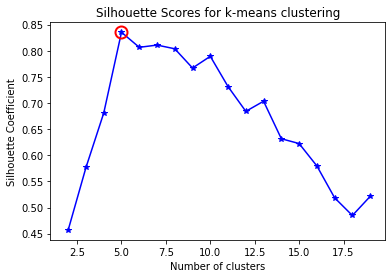

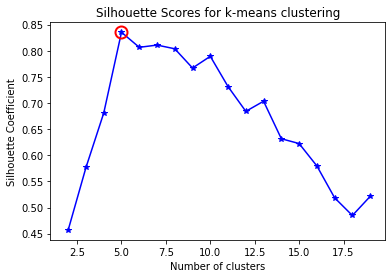

In [0]:
fig, ax = plt.subplots()
plt.plot(range(2,20), cost, 'b*-')
plt.plot(range(2,20)[kIdx], cost[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Scores for k-means clustering')
# Uncomment the next line
display(fig)

### Choose K

In [0]:
k = 5
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-4.12200145  7.41342142  0.3398674 ]
[-6.79561456 -4.03685501 -1.10132675]
[ 4.11111715 -9.61155032  9.41405178]
[ 2.91272407 -3.48350321 -7.44002714]
[-1.37553087 -4.21777547  2.22581078]


#Train Model

In [0]:
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(id='row0', prediction=1), Row(id='row1', prediction=0), Row(id='row2', prediction=0)]


In [0]:
df_pred = spark.createDataFrame(rows)
df_pred.show()

+-----+----------+
|   id|prediction|
+-----+----------+
| row0|         1|
| row1|         0|
| row2|         0|
| row3|         0|
| row4|         1|
| row5|         0|
| row6|         3|
| row7|         0|
| row8|         4|
| row9|         3|
|row10|         1|
|row11|         3|
|row12|         1|
|row13|         0|
|row14|         3|
|row15|         1|
|row16|         0|
|row17|         0|
|row18|         3|
|row19|         4|
+-----+----------+
only showing top 20 rows



In [0]:
df_pred = df_pred.join(df, 'id')
df_pred.show()

+-----+----------+--------------------+-------------------+-------------------+
|   id|prediction|                   x|                  y|                  z|
+-----+----------+--------------------+-------------------+-------------------+
| row0|         1|  -6.077699676970267|-2.9096103057273632|-1.5181728865169748|
| row1|         0| -1.0122600489217026|  7.322841304183577| -5.442407430432608|
| row2|         0|  -8.297006462627731| 6.3228935430154625|  1.167204760454971|
| row3|         0|  -3.507121456057238|  4.784811751712145|  -5.44494747291675|
| row4|         1|   -5.12282340491732| -3.322049741451506|-0.5069804719890176|
| row5|         0|  -2.476400627641164|  8.255790793498251| 4.4094781220223345|
| row6|         3|   7.315395347991067| -5.079448952098217| -7.291214948142356|
| row7|         0|  -2.016746359044601|   9.30345477210614|  7.095178976138996|
| row8|         4|-0.23381850372561575| -4.892681101883508| 2.1228876266871093|
| row9|         3|   6.565442081261875| 

#Verify Model

In [0]:
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,x,y,z
id,,,,
row0,1,-6.077700,-2.909610,-1.518173
row1,0,-1.012260,7.322841,-5.442407
row2,0,-8.297006,6.322894,1.167205
row3,0,-3.507121,4.784812,-5.444947
row4,1,-5.122823,-3.322050,-0.506980


<command-3168712444199847>:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure(figsize=(12,10)).gca(projection='3d')


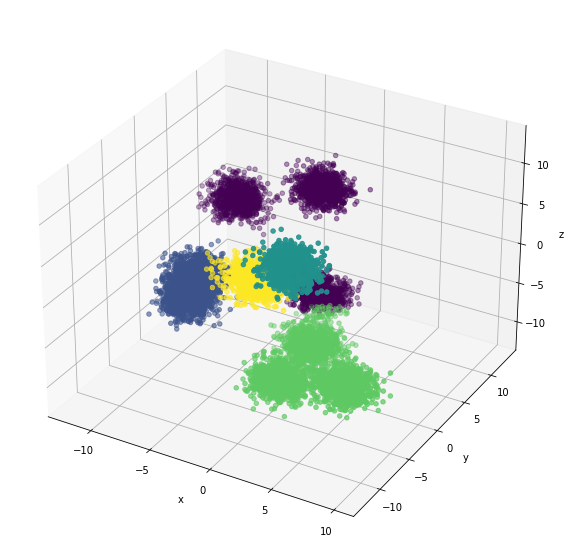

In [0]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

In [0]:
model.save("./KMeansModel")

### Load Model ###
#sameModel = KMeansModel.load(sc, ###)